In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Copyright (c) Meta Platforms, Inc. and affiliates.

This source code is licensed under the CC BY-NC license found in the
LICENSE.md file in the root directory of this source tree.
"""
import pickle
import random
import time
import gym
import numpy as np

import sys
import os
from munch import Munch
import yaml

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from PIL import Image
import os
import pandas as pd


from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from PIL import Image


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
df = pd.read_csv('ema.csv', sep=',')
df = df.sort_values(['subid', 'dttm_obs'])[['dttm_obs', 'subid', 'ema_1', 'ema_2', 'ema_3', 'ema_4', \
                                            'ema_5', 'ema_6', 'ema_7', 'ema_8', 'ema_9', 'ema_10']]

# Handling NA: drop the entire row if 4th entry is NA 
# For morning-only survey, set dummy=1 if survey reported, otherwise dummy=0
df = df.fillna(-6.0)
df = df[df['ema_4'] > -1]
df['ema_dummy'] = (df['ema_8'] > -1)
df.loc[df['ema_8'] < 0, ['ema_8', 'ema_9', 'ema_10']] = 0

# Encoding: 'Yes/No -> 0/1'
df = df.replace('No',0)
df = df.replace('Yes',1)

# Date-time encoding -- in hour unit 
df['date'] = (pd.to_datetime(df['dttm_obs']).astype('int64') // (10**9)) / 3600
df2 = df[['subid', 'ema_1', 'ema_2', 'ema_3', 'ema_4', \
            'ema_5', 'ema_6', 'ema_7', 'ema_8', 'ema_9', 'ema_10', 'ema_dummy', 'date']]


time_df = pd.read_csv('labels_1day.csv', sep=',')
time_df = time_df.sort_values(['subid', 'dttm_label']) 
time_df['date'] = (pd.to_datetime(time_df['dttm_label']).astype('int64') // (10**9)) / 3600
time_df = time_df.replace('no',0)
time_df = time_df.replace('yes',1)

time_df = time_df[['subid', 'lapse', 'date']]

In [4]:
def input_data(org_data, time_label):
    # 24hr window right-index
    fj = 0    
    
    # offset starting date-time to 0 
    offset_time = time_label[0,-1] + 0.0
    org_data[:,-1] -= offset_time
    time_label[:,-1] -= offset_time
    feature = np.mean(org_data[:, 1:-1], axis=0)
    
    # print(feature.shape)
    dataset = []
    tq = ts = 0
    while(tq < time_label.shape[0] and ts < org_data.shape[0] ):
        if(ts == org_data.shape[0] or (tq < time_label.shape[0] and time_label[tq, -1] < org_data[ts, -1])):
            y = 1 if( time_label[tq,1] > 0 ) else 0
            t_feature = np.concatenate([feature, np.mean(org_data[ts:, 2:-1], axis=0)])
            dataset.append({'type':'query', 'out': y, 'time': time_label[tq,-1], 'feature': t_feature})
            while(tq < time_label.shape[0] and time_label[tq,-1] < org_data[ts,-1] ):
                tq += 1
        else:
            dataset.append({'type':'survey', 'obs': org_data[ts, 1:]+0.0, 'time': org_data[ts,-1]})
            ts += 1

    return dataset


In [5]:
raw_data = df2.values.astype(np.float32)
time_raw_data = time_df.values.astype(np.float32)

env_list, subid_list = [], []
print_list = []
for subid in range(270):
    sub_data = raw_data[raw_data[:,0]==(subid+1)]
    time_label = time_raw_data[time_raw_data[:,0]==(subid+1)]
    if( len(sub_data) == 0 or len(time_label) == 0 ):
        continue
          
    subid_list.append(subid)
    print_list.append(subid+1)
    env_list.append(input_data(sub_data, time_label))

print(print_list)

[1, 2, 3, 5, 6, 7, 9, 10, 11, 15, 16, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 42, 43, 44, 47, 48, 51, 52, 53, 54, 56, 58, 59, 63, 64, 65, 66, 74, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 88, 90, 92, 93, 94, 97, 98, 99, 100, 103, 109, 110, 116, 117, 118, 119, 121, 128, 130, 131, 134, 135, 136, 137, 138, 139, 143, 149, 150, 156, 158, 161, 162, 163, 166, 167, 169, 171, 172, 175, 178, 179, 180, 181, 183, 185, 187, 188, 189, 190, 191, 192, 193, 196, 197, 200, 201, 203, 205, 207, 208, 209, 211, 212, 213, 214, 215, 218, 221, 222, 223, 224, 225, 230, 231, 232, 234, 236, 238, 240, 241, 242, 243, 245, 248, 252, 255, 259, 262, 263, 264, 265, 268, 270]


# XGBoost Comparison

In [6]:
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def input_xgboost_data(org_data, time_label):
    j = [0,0,0,0,0]
    fj = 0
    window = [12, 24, 48, 72, 168]
    
    dataset = []
    tq = ts = 0

    while( tq < time_label.shape[0] ):
        time = time_label[tq,-1]

        while( ts < org_data.shape[0] and org_data[ts,-1] < time ):
            ts += 1
        
        for k in range(5):
            while( j[k] < ts-1 and org_data[j[k], -1] < time - window[k] ):
                j[k] = j[k] + 1
                   
        if( ts == 0 ):
            tq += 1
            continue
            
        X1 = np.concatenate(([np.mean(org_data[j[k]:ts, 1:], axis=0) for k in range(5)], \
                            [np.min(org_data[j[k]:ts, 1:], axis=0) for k in range(5)] , \
                            [np.max(org_data[j[k]:ts, 1:], axis=0) for k in range(5)]), axis=1)
        X1 = np.concatenate(X1)

        sub_mean = np.mean(org_data[:ts], axis=0)
        X = np.concatenate((X1, sub_mean[1:]))
        X = np.concatenate((X, org_data[ts-1, 1:]))

        y = 1 if (time_label[tq,1] > 0 ) else 0
        tq += 1
        
        dataset.append({'in':X, 'out':y})

    return dataset


def xgboost_main(train_index, test_index):
    trainset = []
    for m in train_index:
        subid = subid_list[m] + 1
        sub_data = raw_data[raw_data[:,0] == subid] 
        time_label = time_raw_data[time_raw_data[:,0]==subid]                
        trainset.extend(input_xgboost_data(sub_data, time_label))

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=500000, shuffle=True, drop_last=False)

    testset = []
    for m in test_index:
        subid = subid_list[m] + 1
        sub_data = raw_data[raw_data[:,0] == subid]     
        time_label = time_raw_data[time_raw_data[:,0]==subid]                
        testset.extend(input_xgboost_data(sub_data, time_label))

    test_loader = torch.utils.data.DataLoader(testset, batch_size=60000, shuffle=False, drop_last=False)

    data_iter = iter(train_loader)
    train_data = next(data_iter)
    X = train_data['in']
    y = train_data['out']

    test_iter = iter(test_loader)
    test_data = next(test_iter)

    # Create regression matrices
    dtrain_reg = xgb.DMatrix(X, y)

    X_test = test_data['in']
    y_test = test_data['out']
    dtest_reg = xgb.DMatrix(X_test, y_test)

    params = {"objective": "reg:squarederror", "tree_method": "hist", "device": "cuda"}

    print(X.shape, X_test.shape)
    
    n = 10
    xgmodel = xgb.train(
       params=params,
       dtrain=dtrain_reg,
       num_boost_round=n,
    )

    preds = xgmodel.predict(dtest_reg)
    print(len(y_test[y_test>0]), len(preds[preds>0.1]), len(preds))
    print('XgBoost: AUC = %.2f' % roc_auc_score(y_test, preds))  #1


# Environment Configuration

In [7]:
from env import Env, VecEnv

# parallel env runs
num_process = 50
# survey window size (last "window_size" survey received points)
window_size = 25


# action encoding: 
# 0 - no survey, predict No
# 1 - yes survey, predict No
# 2 - no survey, predict Yes
# 3 - yes survey, predict Yes
action_dim = 1
action_max = 4

# feature encoding: mean of survey items
feature_dim = 21

# y encoding
# 0 - no lapse within 24hr
# 1 - yes lapse within 24hr
state_dim, embed_dim, y_max = 12, 256, 2

# Reinforcement Learning

In [8]:

# get trajectory sample batch
def get_sample(traj, model, device):
    beliefs = model(traj['prev_state'], traj['prev_action'], output_embedding=True)
    
    action = traj['action'].reshape(-1, 1).to(device)  # [B, n]
    reward = traj['reward'].reshape(-1, 1).to(device)  # [B, n]
    next_state = model(traj['next_state'], traj['next_action'], output_embedding=True)    
    
    state = beliefs.reshape(-1, embed_dim).detach()
    next_state = next_state.reshape(-1, embed_dim).detach()
    done = traj['done'].to(device)

    return state,action,reward,next_state,done
            
# train function (without extra features)
def train(venv, model, agent, buffer, predict_buffer, max_iter = 50, burn_in = 0, feature_weight = 0.0):
    avg_list = []
    
    feature_optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 2e-5, 'weight_decay': 1e-8}])
    ce_criterion = torch.nn.CrossEntropyLoss(reduction='none')
    mse_criterion = torch.nn.MSELoss(reduction='none')
    env = venv.venv[0]
    
    for episode in range(max_iter):
        obs, info = venv.reset(mode='train')

        cumr = 0
        ts = torch.zeros(num_process,window_size, state_dim).to(device) 
        ta = torch.zeros(num_process,window_size, action_dim).to(int).to(device) 

        bf = model(ts, ta, output_embedding=True).detach()

        sample_traj = []
        predict_samples = []
        
        # generate trajectories
        for t in range(1000):
            if( episode < burn_in ):
                actions = torch.zeros(num_process, action_dim).to(int) + 1
            else:
                actions, _, _ = agent.select_action(bf)
                actions = actions.detach().cpu()
                
            obs, rewards, dones, infos = venv.step(actions)
            cumr += sum(rewards)

            # add transition data to dataset
            all_done = True
            for i in range(num_process):
                if( infos[i] == -1 ):
                    continue
                
                all_done = False
                pts, pta = ts[i] + 0.0, ta[i] + 0
                nts, nta = ts[i] + 0.0, ta[i] + 0
                                
                if (infos[i] != 'survey'):
                    predict_samples.append({'action': nta, 'state': nts, 'out': infos[i]['out'], \
                                            'feature': infos[i]['feature']})
                    ts[i][-1, -1] = obs[i, -1]
                else:    
                    ts[i] = torch.cat([ts[i][1:,:], obs[i].view(-1, state_dim).to(device)], dim=0)
                    ta[i] = torch.cat([ta[i][1:,:], actions[i].view(-1, action_dim).to(device)], dim=0)

                sample_traj.append({'prev_state': pts, 'prev_action': pta, \
                            'action': actions[i], 'reward': rewards[i], \
                            'next_action': nta, 'next_state': nts, \
                            'done': dones[i]})

            if( all_done ): 
                break
                
            bf = model(ts.reshape(num_process,-1,state_dim), ta.reshape(num_process,-1, 1), output_embedding=True).detach()

        avg_cost = cumr / num_process
        avg_list.append(avg_cost)
        
        buffer.add_episodes(sample_traj)
        predict_buffer.add_episodes(predict_samples)
        
        # 1. train prediction first
        train_loaders = predict_buffer.get_loader()
        data_iter = iter(train_loaders)

        for j in range(0, 200):
            try:
                traj = next(data_iter)

                beliefs = model(traj['state'], traj['action'], output_embedding=True)
                out_ys, out_features = model.predict_forward(beliefs)
                ys = traj['out'].to(device).reshape(-1)
                features = traj['feature'].to(device).reshape(-1, feature_dim)

                predict_loss = ce_criterion(out_ys, ys).mean()
                predict_loss += feature_weight * mse_criterion(out_features, features).mean()

                predict_loss.backward()
                feature_optimizer.step()
                feature_optimizer.zero_grad()

            except StopIteration:
                train_loaders = predict_buffer.get_loader()
                data_iter = iter(train_loaders)
                continue

        # 2. then train q
        if( episode < burn_in ):
            continue

        train_loaders = buffer.get_loader()
        data_iter = iter(train_loaders)

        for j in range(0, 500):
            try:
                traj = next(data_iter)
                batch = get_sample(traj, model, device)

            except StopIteration:
                train_loaders = buffer.get_loader()
                data_iter = iter(train_loaders)
                continue

            agent.update(batch)

        agent.update_target()



In [9]:

def test(venv, model, agent, mode='policy', run_id=0, kfold_id=0, penalty=-1.):
    scatter = []
    num_process = len(venv.test_ids)
    
    cnt, n_measure, n_hit = [0 for i in range(num_process)], [0 for i in range(num_process)], [0 for i in range(num_process)]
    y, outy = [], []

    env = venv.venv[0]
    obs, info = venv.reset(mode='test')
    cumr = 0
    
    ts = torch.zeros(num_process, window_size, state_dim).to(device)
    ta = torch.zeros(num_process, window_size, action_dim).to(int).to(device)

    bf = model(ts, ta, output_embedding=True)
    bf = bf.detach()

    for t in range(1000):
        if( mode == 'policy' ):
            actions, _, _ = agent.select_action(bf)
            actions = actions.detach().cpu()
        else:
            actions = torch.zeros(num_process, action_dim).to(int) + 1

        obs, rewards, dones, infos = venv.step(actions)
        cumr += sum(rewards)
        
        predict_ys = model.predict_forward(bf)[0].detach()       
   
        # add transition data to dataset
        all_done = True
        for i in range(num_process):
            if( infos[i] == -1 ):
                continue

            all_done = False
            if (infos[i] != 'survey'):
                check_y = nn.Softmax(dim=-1)(predict_ys[i]).reshape(y_max).detach().cpu()                
                y.append(infos[i]['out'])
                outy.append(check_y[1])
            
                ts[i][-1, -1] = obs[i, -1]
                
            else:    
                ts[i] = torch.cat([ts[i][1:,:], obs[i].view(-1, state_dim).to(device)], dim=0)
                ta[i] = torch.cat([ta[i][1:,:], actions[i].view(-1, action_dim).to(device)], dim=0)

                cnt[i] += 1
                if( actions[i] % 2 == 1 ):
                    n_measure[i] += 1
                if( obs[i,0] > 0 ):
                    n_hit[i] += 1

        if( all_done ): 
            break
                
        bf = model(ts.reshape(num_process,-1,state_dim), ta.reshape(num_process,-1, action_dim), output_embedding=True).detach()

    for i in range(num_process):
        scatter.append([n_measure[i]/cnt[i], n_hit[i]/cnt[i]])
        print(venv.test_ids[i], ':', n_measure[i], n_hit[i], cnt[i])
    
    path = os.path.join("./results", f"run_{run_id}_kfold_{kfold_id}_penalty_{penalty}.pt")
    things_to_save = {
        'test_ids': venv.test_ids,
        'model_state_dict': model.state_dict(),
        'agent_state_dict': agent.save_dict()
    }
    torch.save(things_to_save, path)
    
    
    scatter = np.array(scatter)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4, 3))  

    plt.scatter(scatter[:,1], scatter[:,0])
    plt.xlabel("Average Lapse Count")
    plt.ylabel("Survey Ratio")
    plt.show()

    print('Average Survey Ratio:', np.mean(scatter[:,0]))

    import xgboost as xgb
    from sklearn import metrics
    from sklearn.metrics import roc_auc_score
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split

    print('AUC = %.2f' % roc_auc_score(y, outy))  #1

    
    

# Test Reinforcement Learning Result

In [10]:
import random
from SACD import init_SACD_agent
from model import build_model
from buffer import ReplayBuffer
  
import torch.nn.functional as F
import time
import copy

def k_fold_test(k=5, run_id=0):
    shuffled_index = list(range(151))
    random.shuffle(shuffled_index)

    for i in range(k):
        st,et = i*151//k, (i+1)*151//k

        test_index = shuffled_index[st:et]
        train_index = list(set(range(151)) - set(test_index))
        xgboost_main(train_index, test_index)
        venv = VecEnv(env_list, train_index, test_index)
        env = venv.venv[0]
        
        buffer = ReplayBuffer()
        predict_buffer = ReplayBuffer()
        model = build_model(embed_dim, state_dim, action_dim, feature_dim, action_max, y_max, model_family='gpt2').to(device)
        agent = init_SACD_agent(state_dim, action_dim, action_max, device, belief_dim=embed_dim, \
                                lr_actor=1e-4, lr_critic=2e-4, entropy_regularizer=0.03)

        # init predictor part
        venv.set_probe_penalty(0.00)
        train(venv, model, agent, buffer, predict_buffer, 25, burn_in=20)
        
        # Test full observation-prediction
        test(venv, model, agent, 'full', run_id=run_id, kfold_id=i, penalty=-1)

        for penalty in [0.02, 0.05, 0.08, 0.12]:
            venv.set_probe_penalty(penalty)
            train(venv, model, agent, buffer, predict_buffer, 10)
            test(venv, model, agent, run_id=run_id, kfold_id=i, penalty=penalty)

        print('-----------------------------------------------')
        print('what about feature-weighted training?')

        # init predictor part
        venv.set_probe_penalty(0.00)
        train(venv, model, agent, buffer, predict_buffer, 25, burn_in=20, feature_weight=0.2)
        
        # Test full observation-prediction
        test(venv, model, agent, 'full', run_id=run_id, kfold_id=i, penalty=-1)

        for penalty in [0.02, 0.05, 0.08, 0.12]:
            venv.set_probe_penalty(penalty)
            train(venv, model, agent, buffer, predict_buffer, 10, feature_weight=0.2)
            test(venv, model, agent, run_id=run_id, kfold_id=i, penalty=penalty)
            
        print('===============================================')
        

torch.Size([218316, 204]) torch.Size([55823, 204])
4691 14827 55823
XgBoost: AUC = 0.87
number of parameters: 0.79M
Device set to : cuda:0
39 : 207 28 207
104 : 297 0 297
20 : 234 0 234
56 : 300 55 300
97 : 320 6 320
37 : 284 9 284
88 : 300 1 300
75 : 302 0 302
2 : 338 9 338
4 : 332 0 332
19 : 262 0 262
30 : 338 19 338
17 : 296 2 296
103 : 320 0 320
47 : 101 0 101
109 : 250 0 250
131 : 184 3 184
63 : 342 56 342
27 : 305 3 305
141 : 343 0 343
5 : 336 18 336
117 : 291 0 291
105 : 343 7 343
129 : 305 1 305
1 : 280 5 280
18 : 348 5 348
81 : 334 0 334
92 : 177 0 177
67 : 282 19 282
87 : 325 6 325


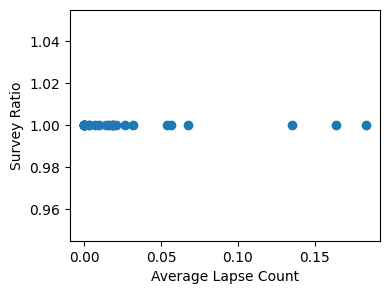

Average Survey Ratio: 1.0
AUC = 0.85



KeyboardInterrupt



In [11]:
k_fold_test(5, 1)